In [17]:
import torch
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show,output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook,export_png
from bokeh.layouts import column,gridplot
#from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [18]:
train=pd.read_excel(r"../data/chem_train.xlsx")
test=pd.read_excel(r"../data/chem_test.xlsx")

In [19]:
train_predict=train.copy()
train=train.loc[(train.corrected_week>0)&(train.corrected_week<53),:]
test_predict=test.copy()
test=test.loc[(test.corrected_week>0)&(test.corrected_week<53),:]

In [20]:
gpr=torch.load("../models/no2_seasonality",weights_only=False,map_location='cuda')

In [21]:
gpr_bc=torch.load("../models/nox_seasonality",weights_only=False,map_location='cuda')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
linmod=torch.linspace(0,52,800).to(device)
pm25_model,pm25_model_std=gpr(linmod,full_cov=True)

linmod_np=linmod.cpu().detach().numpy()
pm25_model_np,pm25_model_std_np=pm25_model.cpu().detach().numpy().copy(),pm25_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1 = pm25_model_np - pm25_model_std_np
upper1 = pm25_model_np + pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1],index=["corrected_week","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

In [24]:

bc_model,bc_model_std=gpr_bc(linmod, full_cov=True)
bc_model_np,bc_model_std_np=bc_model.cpu().detach().numpy().copy(),bc_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_bc = bc_model_np - bc_model_std_np
upper1_bc = bc_model_np + bc_model_std_np
data1_bc=pd.DataFrame([linmod_np,lower1_bc,upper1_bc],index=["corrected_week","lower_bc","upper_bc"]).T
data1_bc = ColumnDataSource(data1_bc.reset_index())

In [25]:
train_predict

Unnamed: 0.1  cpnr  Unnamed: 0  maalnr  constrution_year   Area  \
0                0   419      1030.0     2.0            1968.0  136.0   
1                1   123       291.0     1.0            1980.0  142.0   
2                2   123       292.0     2.0            1980.0  142.0   
3                3   123       293.0     3.0            1980.0  142.0   
4                4   244       593.0     1.0            1965.0  121.8   
...            ...   ...         ...     ...               ...    ...   
1125             0   274       666.0     3.0            1962.0   75.0   
1126             0   427      1052.0     2.0            1959.7   99.1   
1127             0   119       284.0     1.0            1890.0  205.0   
1128             0   119       286.0     3.0            1890.0  205.0   
1129             0   335       809.0     1.0            1950.2  110.3   

      floor_level  powerplant     road  motorway  ...  gastove  fireplace  \
0             0.0         0.0  11552.2       0.0  ...     12.0       36.0   
1             0.0         0.0  15368.2       0.0  ...      0.0       25.0   
2             0.0         0.0  15368.2       0.0  ...     20.0       30.0   
3             0.0         0.0  15368.2       0.0  ...     20.0       30.0   
4             0.0       195.3  19826.0    3023.1  ...      0.0        0.0   
...           ...         ...      ...       ...  ...      ...        ...   
1125          1.0         7.1  15685.2     560.9  ...    300.0        0.0   
1126          0.0       121.6  27399.0    1828.9  ...      0.0       15.0   
1127          0.0         0.0   2756.2       0.0  ...      0.0      240.0   
1128          0.0         0.0   2756.2       0.0  ...      0.0      245.0   
1129          0.0       183.2  24299.7    1964.6  ...    255.0        0.0   

      visit   no2   nox  formaldehyd    acetald    acetone  sample_time  \
0         2   7.0  49.1    29.701935   2.751132   1.850476           71   
1         1   6.9   8.5    12.600000  11.700000  10.100000           83   
2         2   6.3   4.8    28.672236  10.675329  15.106293           70   
3         3   6.3  20.7    24.177584  11.346237   5.677348           76   
4         1   8.7  19.7    23.691806   3.526763   3.829447           74   
...     ...   ...   ...          ...        ...        ...          ...   
1125      3  10.9  18.5    22.992311   2.211332   5.277120           71   
1126      2  13.6  65.4    22.928374   1.834360   1.809277           91   
1127      1   5.7  22.2     9.300000   8.300000   8.900000           72   
1128      3   5.3  12.2    11.530052   8.254482   5.024362           88   
1129      1  11.6  51.8    13.400347  10.737955  11.374607           71   

      corrected_week  
0          44.000000  
1          50.857143  
2          29.571429  
3          47.285714  
4          42.571429  
...              ...  
1125      -17.585714  
1126       -8.157143  
1127       -4.014286  
1128       -4.728571  
1129       -1.871429  

[1130 rows x 28 columns]

In [26]:
def roll_week(data,resolution,week,particle):
    mean=[]
    std=[]
    x=np.linspace(0,53,resolution,endpoint=True)
    sort=data.sort_values("corrected_week")
    list_std=[particle+"_std" for particle in particle]
    for i in x:
        mean.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].mean())
        std.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].std())
    mean_1,std_1=pd.DataFrame(mean,index=x),pd.DataFrame(std,index=x)
    std_1.columns=std_1.columns+"_std"
    data=pd.concat([mean_1,std_1],axis=1)
    return data.set_index(x)

In [38]:
resolution=500
week_averange=3
mean=roll_week(train_predict,resolution,week_averange,["no2","nox"])
mean_test=roll_week(test_predict,resolution,week_averange,["no2","nox"])
x=np.linspace(0,53,resolution,endpoint=True)
nox=gpr_bc(torch.tensor(x).float().to(device))[0].cpu().detach().numpy()
no2=gpr(torch.tensor(x).float().to(device))[0].cpu().detach().numpy()

In [39]:
lower1_std = mean.no2 - mean.no2_std
upper1_std = mean.no2 + mean.no2_std
lower1_bc_std  = mean.nox - mean.nox_std
upper1_bc_std  = mean.nox + mean.nox_std
mean["lower1_std_pm"]=lower1_std
mean["upper1_std_pm"]=upper1_std
mean["lower1_std_bc"]=lower1_bc_std
mean["upper1_std_bc"]=upper1_bc_std

mean=mean.dropna()
mean1 = ColumnDataSource(mean.reset_index())

In [40]:
r2_no2_test,r2_nox_test=r2_score(mean_test.no2,no2),r2_score(mean_test.nox,nox)
r2_no2,r2_nox=r2_score(mean.no2,no2),r2_score(mean.nox,nox)

In [41]:
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

Loading BokehJS ...

In [42]:
output_file(filename="custom_filename.html", title="Static HTML file")
p = figure(x_range=(0, 53),y_range=(5, 18));
p.title.text = r" $$NO_2$$ seasonality";
p.xgrid.grid_line_color=None;
p.ygrid.grid_line_alpha=0.5;
p.line(mean_test.index, mean_test.no2, line_width=3,color="orange",legend_label="test roll mean R2 "+str(round(r2_no2_test,2)));
p.line(mean.index, mean.no2, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(r2_no2,2)));
p.line(linmod_np, pm25_model_np, line_width=3,color="red",legend_label="Gaussion model");
p.scatter(train.corrected_week, y=train.no2, color="blue", marker="dot", size=20, alpha=0.4,legend_label="raw points");
band = Band(base="index", lower="lower1_std_pm", upper="upper1_std_pm",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
band1 = Band(base="corrected_week", lower="lower", upper="upper",source=data1,fill_alpha=0.5, fill_color="blue", line_color="black");
p.yaxis.axis_label_orientation  = 0
p.add_layout(band);
p.add_layout(band1);
p.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p.yaxis.axis_label = r'$$\frac{\mu g}{m^3} $$';
p1 = figure(x_range=(0, 53),y_range=(0, 80));
p1.title.text = r" $$NO_x$$ seasonality";
p1.xgrid.grid_line_color=None;
p1.ygrid.grid_line_alpha=0.5;
p1.line(mean.index, mean.nox, line_width=3,color="green",legend_label="train roll mean R2 "+str(round(r2_nox,2)));
p1.line(mean_test.index, mean_test.nox, line_width=3,color="orange",legend_label="test roll mean R2 "+str(round(r2_nox_test,2)));

p1.line(linmod_np, bc_model_np, line_width=3,color="red",legend_label="Gaussion model");
p1.scatter(train.corrected_week, y=train.nox, color="blue", marker="dot", size=20, alpha=0.8,legend_label="raw points");
band2 = Band(base="corrected_week", lower="lower_bc", upper="upper_bc",source=data1_bc, fill_color="blue", line_color="black",fill_alpha=0.5);
band3 = Band(base="index", lower="lower1_std_bc", upper="upper1_std_bc",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
p1.add_layout(band3);
p1.add_layout(band2);
p1.yaxis.axis_label_orientation  = 0
p1.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p1.yaxis.axis_label = r'$$ \frac{\mu g}{m^3} $$';
p1.legend.title_text_font_size = "16px";
p.legend.title_text_font_size = "16px";
p.xaxis.axis_label_text_font_size = "14px";
p.yaxis.axis_label_text_font_size = "14px";
p1.xaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_size = "14px";
p1.yaxis.axis_label_text_font_style = "bold";
p1.xaxis.axis_label_text_font_style = "bold";
p.yaxis.axis_label_text_font_style = "bold";
p.xaxis.axis_label_text_font_style = "bold";
grid =  gridplot([[p, p1]], width=500, height=500);

show(column(grid));

In [43]:
export_png(grid, filename="plot.png")

RuntimeError: To use bokeh.io image export functions you need selenium ('conda install selenium' or 'pip install selenium')

In [32]:
mean_test.no2

0      5.600000
116    5.933333
188    6.475000
190    6.540000
161    5.900000
         ...   
187    8.527451
7      8.549020
16     8.558824
150    8.633333
134    8.723529
Name: no2, Length: 206, dtype: float64

(-8.789999581335133, 0.42744850280136937)

In [19]:

r2_score(test.no2,test_2),r2_score(test.nox,test_1)

(0.01757199704468093, 0.21253558332567046)

In [20]:
r2_score(test.no2,test_2),r2_score(test.nox,test_1)

(0.01757199704468093, 0.21253558332567046)

In [52]:
pyro_data=az.from_json("../Arviz_stats/mcmc_nox_seasonality.json")

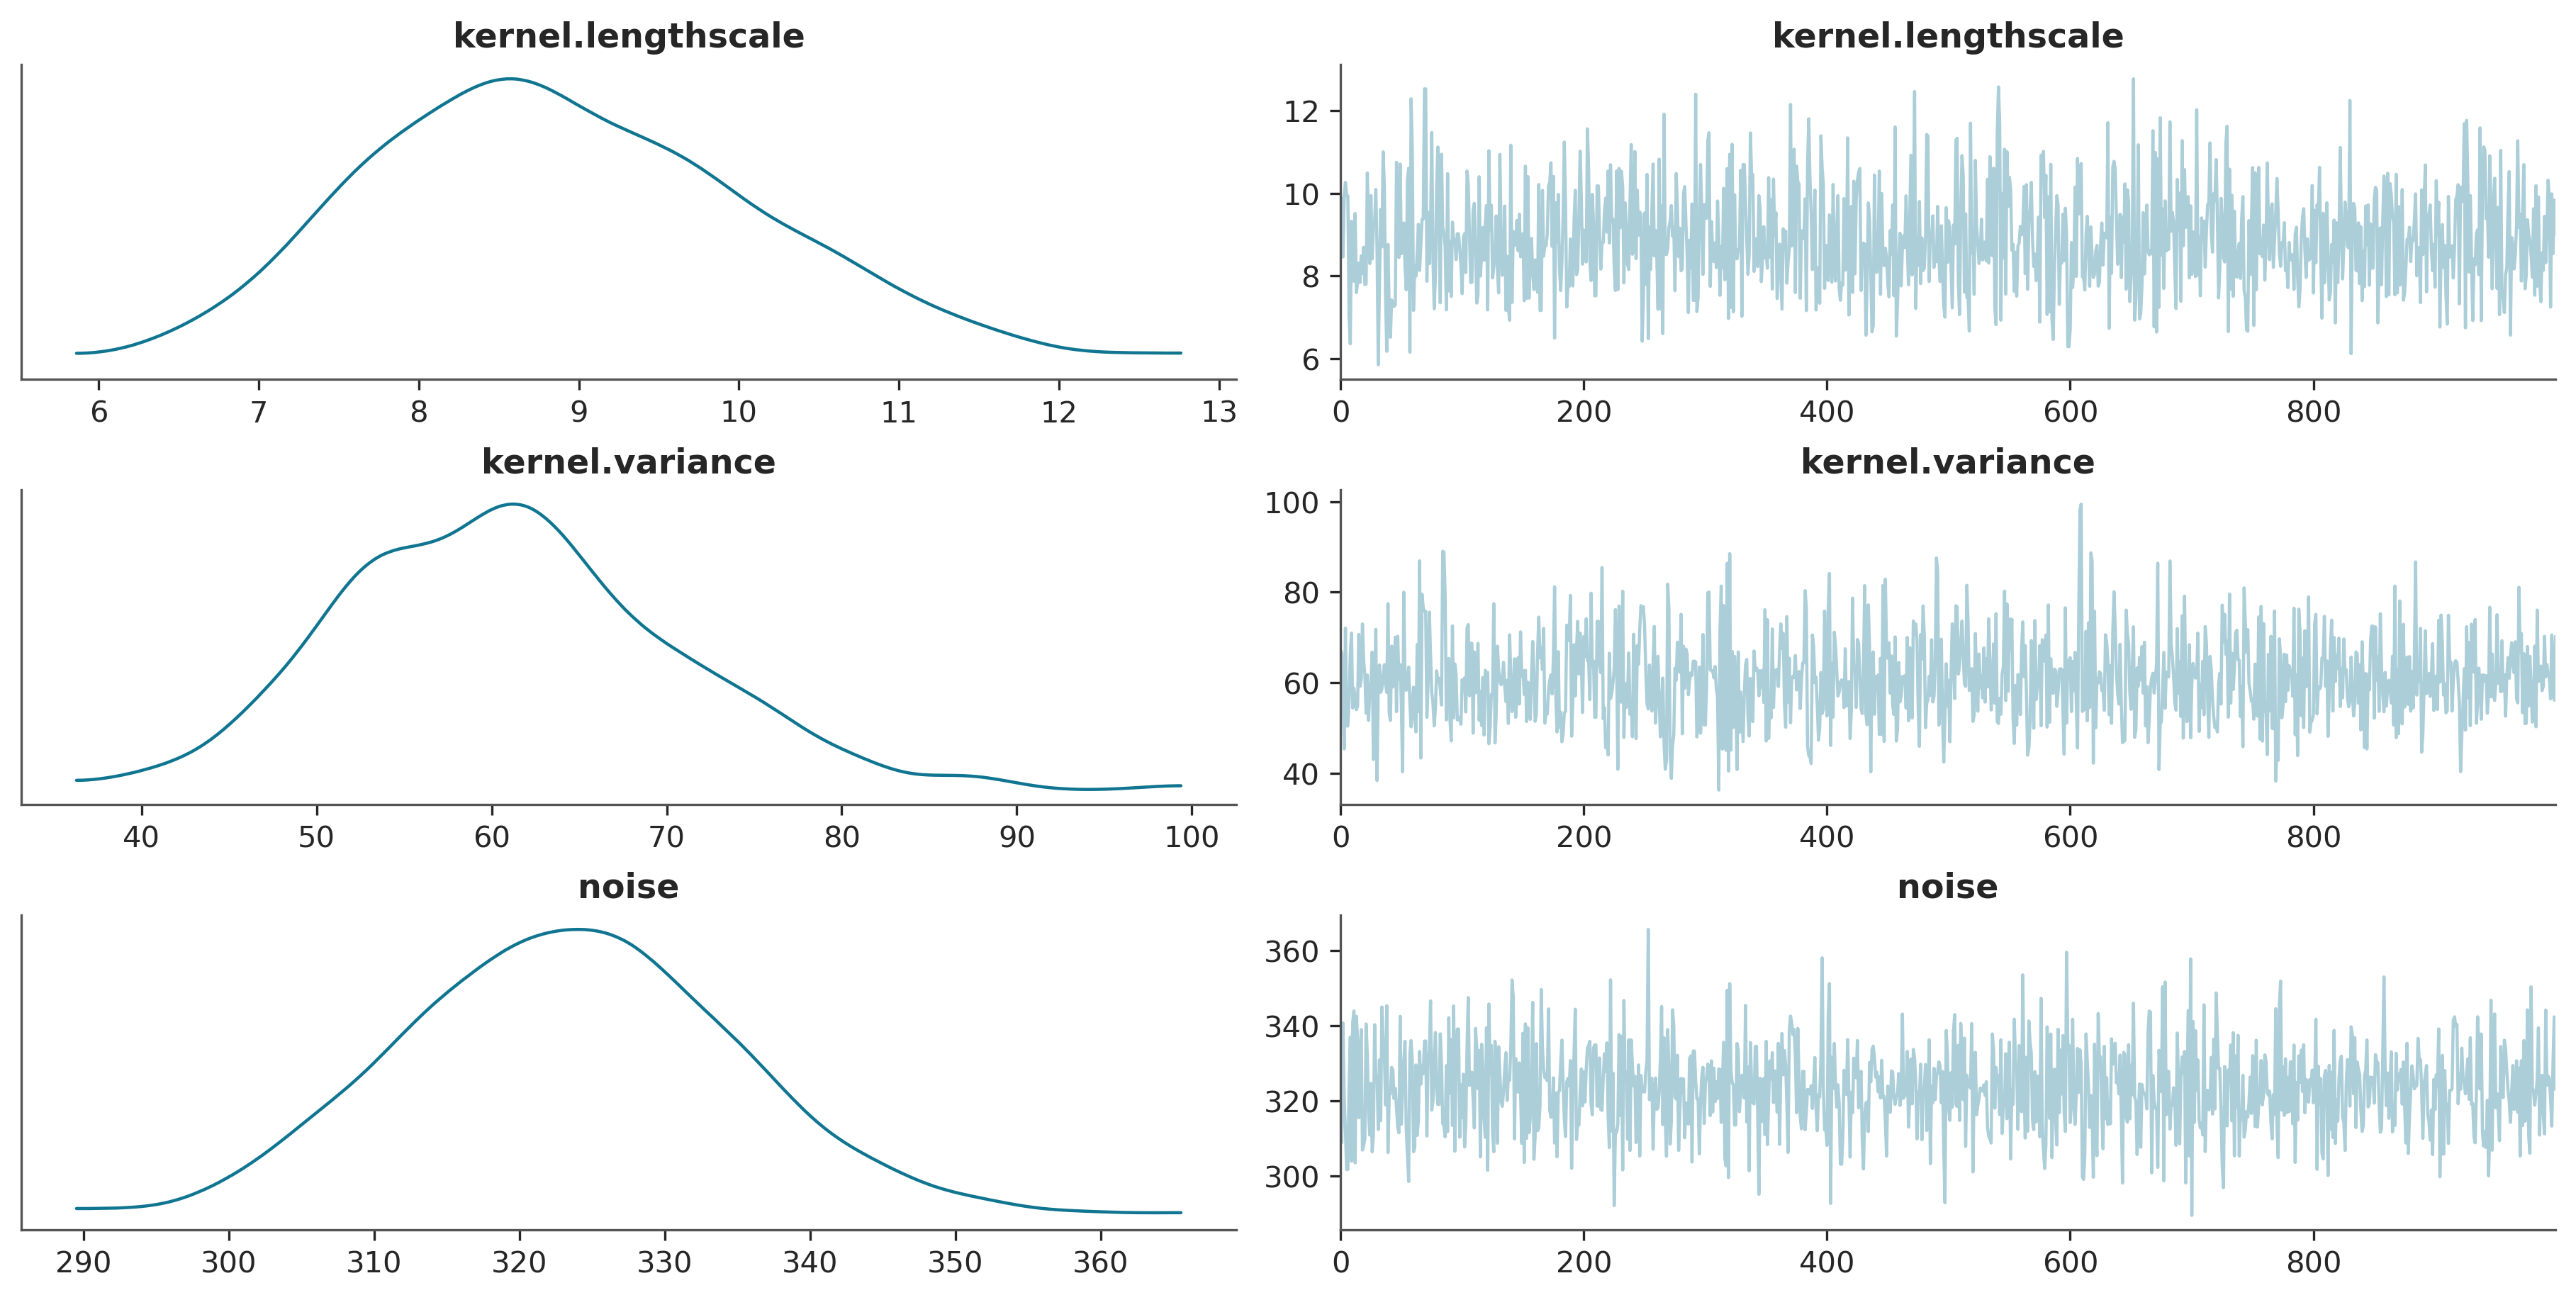

In [53]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data)

In [54]:
ax = az.plot_density(
    pyro_data,backend='bokeh'
)

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

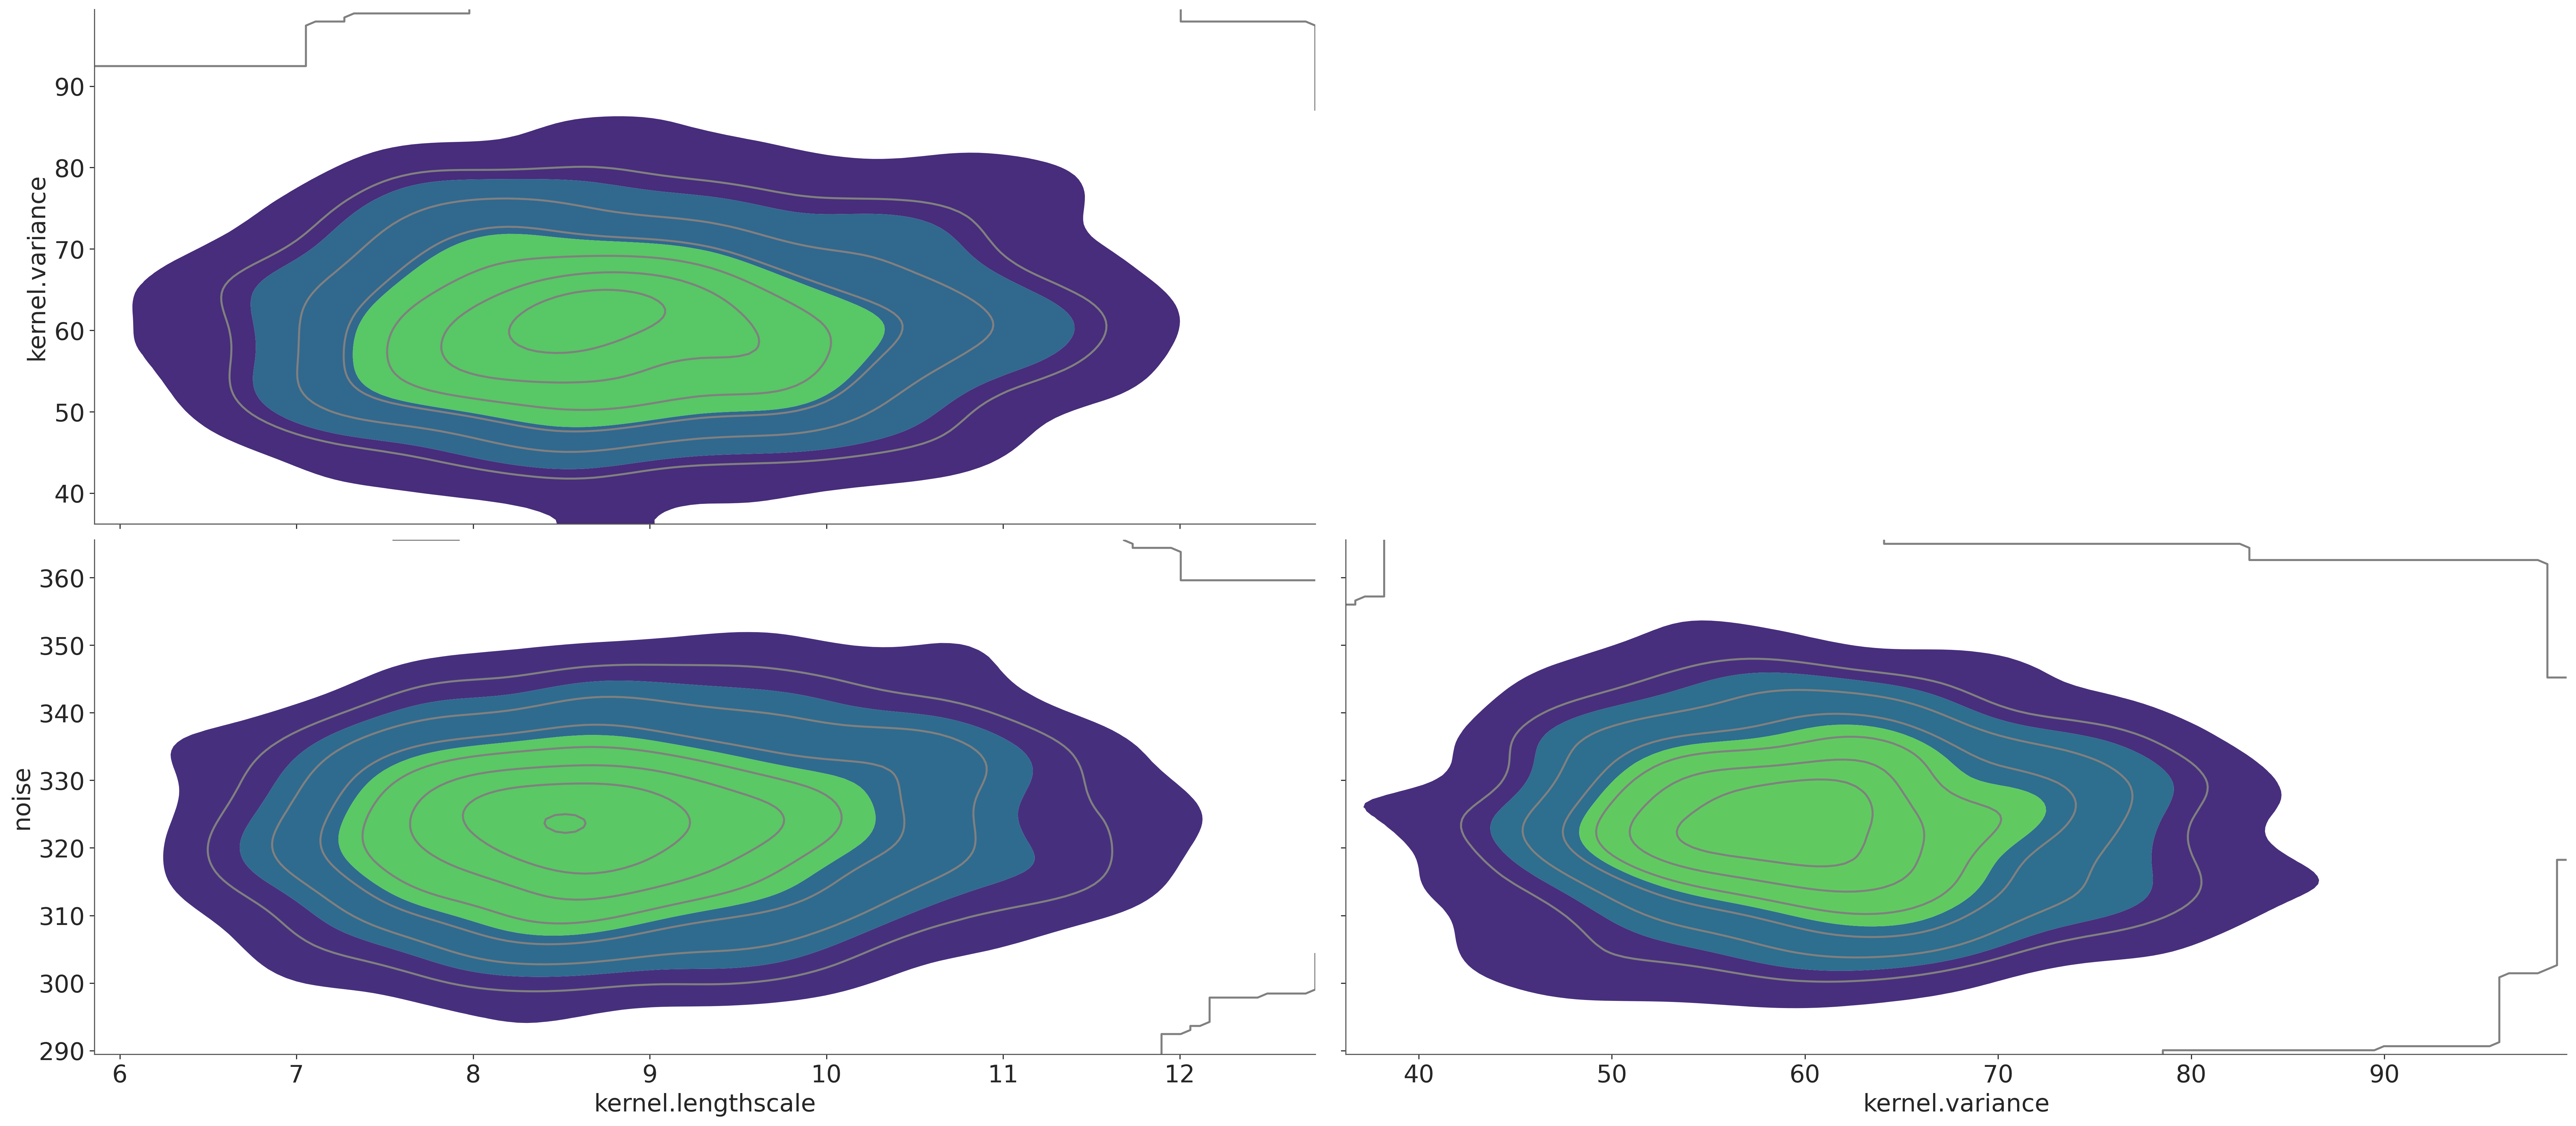

In [55]:
az.plot_pair(pyro_data,kind='kde',divergences=True,textsize=18)


In [56]:
pyro_data_bc=az.from_json("../Arviz_stats/mcmc_nox_seasonality.json")

In [57]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_bc,backend='bokeh')

In [58]:
ax = az.plot_density(
    [pyro_data_bc],
    shade=0.1,backend='bokeh'
)

array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

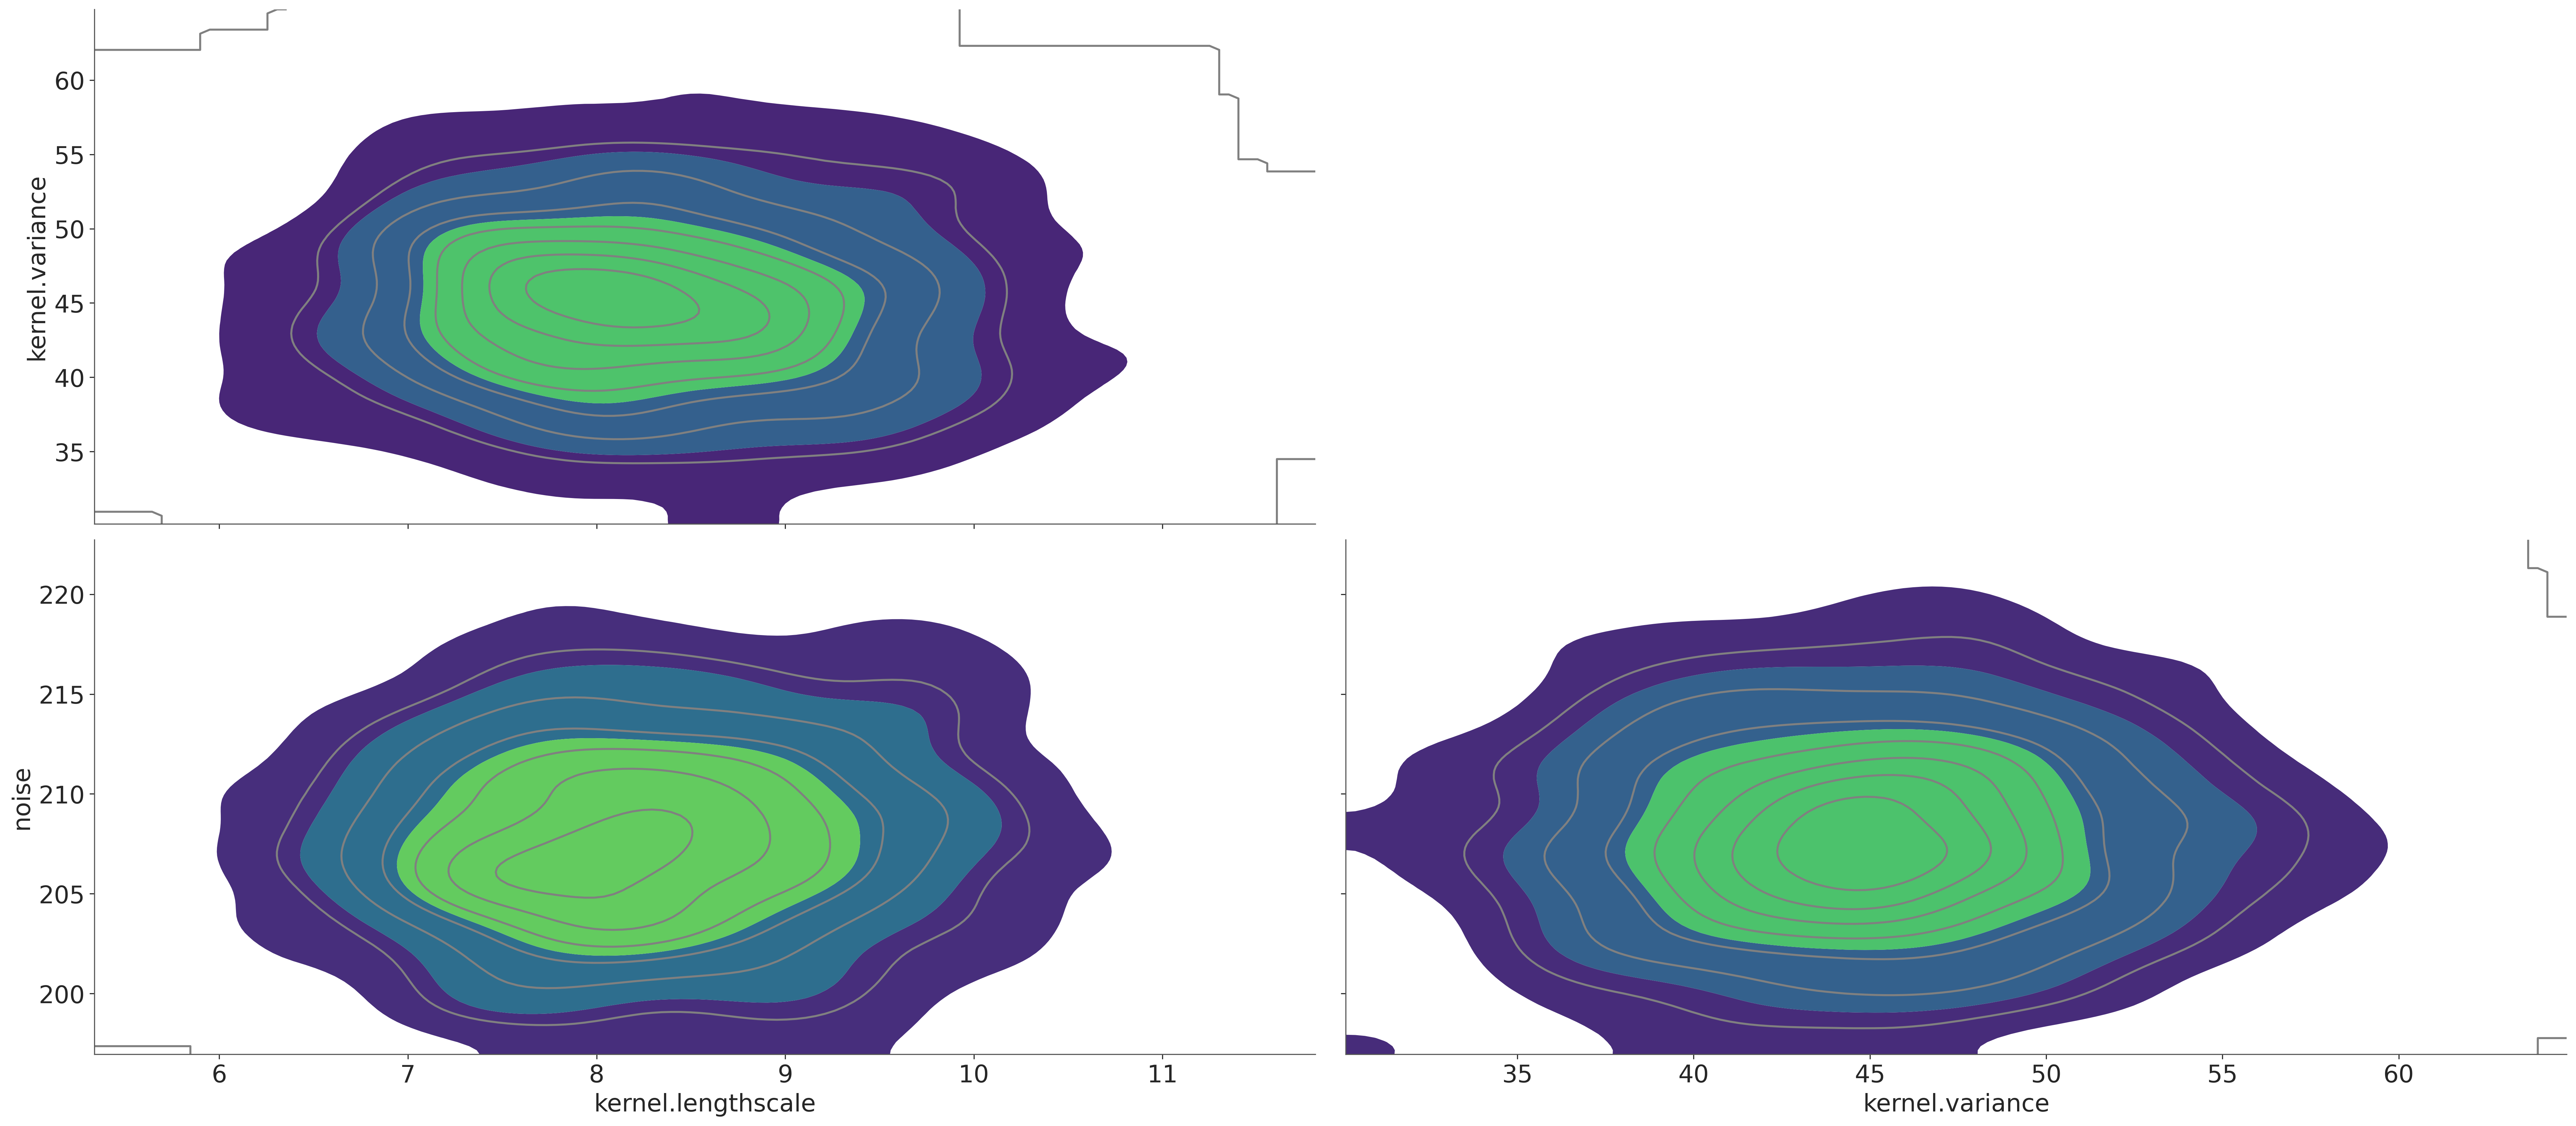

In [20]:
az.plot_pair(pyro_data_bc,kind='kde',divergences=True,textsize=18)
